In [94]:
import re
import string
import pandas as pd
import matplotlib as pyplot

from gensim.models import Word2Vec

%matplotlib inline

In [5]:
quran_df = pd.read_csv('../data/quran_data.csv')

In [59]:
quran_df.isna().sum()

Surah Name              0
Surah Number            0
Verse Number            0
Verse Text              0
Number of Words         0
Number of Characters    0
dtype: int64

In [6]:
hadith_df = pd.read_csv('../data/all_hadiths_clean.csv')

In [7]:
hadith_df.head()

,id,hadith_id,source,chapter_no,hadith_no,chapter,chain_indx,text_ar,text_en
0,0,1,Sahih Bukhari,1,1,Revelation - كتاب بدء الوحى,"30418, 20005, 11062, 11213, 11042, 3",حدثنا الحميدي عبد الله بن الزبير، قال حدثنا سف...,Narrated 'Umar bin Al-Khattab: ...
1,1,2,Sahih Bukhari,1,2,Revelation - كتاب بدء الوحى,"30355, 20001, 11065, 10511, 53",حدثنا عبد الله بن يوسف، قال أخبرنا مالك، عن هش...,Narrated 'Aisha: ...
2,2,3,Sahih Bukhari,1,3,Revelation - كتاب بدء الوحى,"30399, 20023, 11207, 11013, 10511, 53",حدثنا يحيى بن بكير، قال حدثنا الليث، عن عقيل، ...,Narrated 'Aisha: (the m...
3,3,4,Sahih Bukhari,1,4,Revelation - كتاب بدء الوحى,"11013, 10567, 34",قال ابن شهاب وأخبرني أبو سلمة بن عبد الرحمن، أ...,Narrated Jabir bin 'Abdullah Al-Ansari while ...
4,4,5,Sahih Bukhari,1,5,Revelation - كتاب بدء الوحى,"20040, 20469, 11399, 11050, 17",حدثنا موسى بن إسماعيل، قال حدثنا أبو عوانة، قا...,Narrated Said bin Jubair: ...


In [9]:
len(hadith_df)

34441

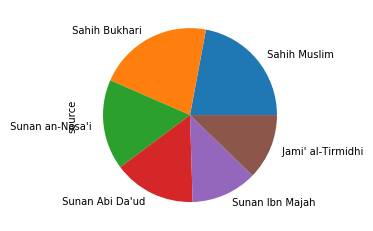

In [15]:
hadith_df.source.value_counts().plot(kind='pie')

In [42]:
hadith_df['Number of Words'] = hadith_df['text_ar'].str.split().str.len()
hadith_df['Number of Characters'] = hadith_df['text_ar'].str.len()

In [45]:
hadith_df['Number of Words'].sum()

2410879.0

In [47]:
quran_df['Number of Words'] = quran_df['Verse Text'].str.split().str.len()
quran_df['Number of Characters'] = quran_df['Verse Text'].str.len()

In [48]:
quran_df['Number of Words'].sum()

77797

In [52]:
quran_df.columns

Index(['Surah Name', 'Surah Number', 'Verse Number', 'Verse Text',
       'Number of Words', 'Number of Characters'],
      dtype='object')

In [51]:
hadith_df.columns

Index(['id', 'hadith_id', 'source', 'chapter_no', 'hadith_no', 'chapter',
       'chain_indx', 'text_ar', 'text_en', 'Number of Words',
       'Number of Characters'],
      dtype='object')

In [65]:
documents = quran_df['Verse Text'].append(hadith_df['text_ar'].dropna())

In [68]:
len(documents)

40669

In [86]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)


def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text


def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text


def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)


def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

def remove_weird_chars(text):
    return text.replace('\u200f', '')

In [87]:
cleaning_funcs = [normalize_arabic, remove_diacritics, remove_punctuations, remove_weird_chars]

In [88]:
clean_documents = []

for document in documents:

    for f in cleaning_funcs:
        document = f(document)
    # Tokenize Arabic Text Properly     
    clean_documents.append(document.strip().split())

In [95]:
model = Word2Vec(clean_documents, 
                 min_count=3,   # Ignore words that appear less than this
                 size=200,      # Dimensionality of word embeddings
                 workers=4,     # Number of processors (parallelisation)
                 window=5,      # Context window for words during training
                 iter=30)       # Number of epochs training over corpus

In [96]:
model.similarity('باب', 'مفتاح')

/Users/uwaisiqbal/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.18780719

In [103]:
model.most_similar('رجل')

/Users/uwaisiqbal/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('اعرابي', 0.5652859210968018),
 ('رجلا', 0.5009067058563232),
 ('ناس', 0.4700668454170227),
 ('برجل', 0.4622243046760559),
 ('انسان', 0.43585526943206787),
 ('نفر', 0.3981330394744873),
 ('رجلان', 0.3844468295574188),
 ('اناس', 0.3757505416870117),
 ('الرجل', 0.37459415197372437),
 ('رجال', 0.3676767349243164)]